# CMIP6 Compute GSL

**Following steps are included in this script:**

1. Load netCDF files
2. Compute GSL

Save and replace netcdf files

In [1]:
import sys
import os
import dask
import xarray as xr
from dask.diagnostics import ProgressBar
import pandas as pd
import cftime
import numpy as np

# Define the full path to the data_handling directory and the config file
data_handling_dir = '/work/ch0636/g300115/phd_project/common/src/data_handling'
config_dir = '/work/ch0636/g300115/phd_project/common/src'

# Add the directories to sys.path
sys.path.append(data_handling_dir)
sys.path.append(config_dir)

# Now import the functions from load_preprocessed_data.py and config
import load_data as ld
import process_data as pro_dat
import save_data_as_nc as sd
from config import BASE_DIR, DEFAULT_MODEL, DEFAULT_VARIABLE, DEFAULT_TEMPORAL_RES, DEFAULT_EXPERIMENT

### Functions

In [2]:
def calculate_monthly_mean(ds, variable):
    """
    Calculate the mean for each month across all years for a given variable in the dataset.

    Parameters:
    ds (xarray.Dataset): The input dataset.
    variable (str): The name of the variable to calculate the monthly mean for.

    Returns:
    xarray.Dataset: A dataset containing the monthly mean for the specified variable.
    """
    # Calculate the monthly mean
    monthly_means = ds[variable].groupby('time.month').mean('time')

    # Create a new dataset for the monthly means
    monthly_mean_ds = xr.Dataset({variable: monthly_means})

    # Copy attributes from the original dataset and variable
    monthly_mean_ds.attrs = ds.attrs
    monthly_mean_ds[variable].attrs = ds[variable].attrs
    monthly_mean_ds[variable].attrs['description'] = f'Monthly mean of {variable}'

    return monthly_mean_ds

In [3]:
def calculate_gsl(ds_dict, season='all'):
    for name, ds in ds_dict.items():
        print(ds.source_id)
        monthly_mean_ds = calculate_monthly_mean(ds, 'lai')
        gsl_ds = calculate_growing_season_length(monthly_mean_ds, season=season)
        ds_dict[name] = gsl_ds
        
    return ds_dict

In [4]:
def calculate_growing_season_length(ds_monthly_mean, season):
    lai = ds_monthly_mean['lai']

    # Create a DataArray for storing the growing season length
    growing_season_length = xr.DataArray(
        np.nan, 
        dims=('lat', 'lon'), 
        coords={'lat': ds_monthly_mean.lat, 'lon': ds_monthly_mean.lon}
    )
    
    seasons_to_months = {
        'winter': [12, 1, 2],
        'spring': [3, 4, 5],
        'summer': [6, 7, 8],
        'fall': [9, 10, 11],
        'period': range(1, 13)
    }
    
    selected_months = seasons_to_months[season]
    
    print(f'{season}: {selected_months}')

    for lat in ds_monthly_mean.lat.values:
        for lon in ds_monthly_mean.lon.values:
            lai_ts = lai.sel(lat=lat, lon=lon)

            # Check if the LAI time series is entirely NaN (ocean cell)
            if lai_ts.isnull().all():
                continue  # Skip this cell, it remains NaN in growing_season_length

            monthly_pct_change = calculate_monthly_pct_change(lai_ts)
            starts, ends = detect_season_starts_and_ends(monthly_pct_change)
            if season == 'winter':
                length = winter_gsl_algorithm(starts, ends, selected_months)
            elif season == 'period':
                length = calculate_season_length(starts, ends)
            else:
                length = gsl_algorithm(starts, ends, selected_months)
            growing_season_length.loc[dict(lat=lat, lon=lon)] = length

    # Create a new dataset for the growing season length
    ds_growing_season_length = xr.Dataset()
    ds_growing_season_length[f'gsl'] = growing_season_length
    ds_growing_season_length[f'gsl'].attrs = {
        'description': f"Mean growing season length over the {season}",
        'calculated_from': 'LAI',
        'season': season,
        'units': '',
        'long_name': 'Growing Season Length' 
    }
    
    ds_growing_season_length.attrs = ds_monthly_mean.attrs
    ds_growing_season_length.attrs['table_id'] = season
    

    return ds_growing_season_length

In [5]:
def winter_gsl_algorithm(starts, ends, selected_months):
     # Set december to month number 0
    # Adjust starts and ends lists if December is present, setting it to month number 0
    # and ensuring selected_months reflects winter months [0, 1, 2]
    starts = [0 if month == 12 else month for month in starts]
    ends = [0 if month == 12 else month for month in ends]

    # If any start or end was adjusted to 0, indicating December was present,
    # then set selected_months for winter
    if 0 in starts or 0 in ends:
        selected_months = [0, 1, 2]
    
    total_growing_season_length = 0
    
    for start, end in zip(starts, ends): 
        # Start in SM & End in SM
        if start in selected_months and end in selected_months:
            if start < end:
                growing_season_length = end - start
            elif start > end:
                if start == 1:
                    growing_season_length = 2
                else:
                    growing_season_length = (2 - start + 1) + (end)
        # Start in SM & End not
        elif start in selected_months and end not in selected_months:
            position = selected_months.index(start)
            growing_season_length = len(selected_months) - (position)
        # End in SM & Start not
        elif start not in selected_months and end in selected_months:
            selected_months.reverse()
            position = selected_months.index(end)
            growing_season_length = max(0, len(selected_months) - position - 1)
            selected_months.reverse()
        # Start not in SM & End not in SM
        elif start not in selected_months and end not in selected_months:
            if start <= end: 
                growing_season_length = 0
            elif start > end: 
                growing_season_length = 3
        # Combination missing
        else:
            raise ValueError("The start and end combination for the growing season is missing or invalid.")
        
        total_growing_season_length += growing_season_length

    # Revert starts and ends from 0 to 12 if they were previously adjusted to represent December
    starts = [12 if month == 0 else month for month in starts]
    ends = [12 if month == 0 else month for month in ends]

    # If December (12) is now present in starts or ends, adjust selected_months for winter
    if 12 in starts or 12 in ends:
        selected_months = [12, 1, 2]
    
    return total_growing_season_length

In [6]:
def gsl_algorithm(starts, ends, selected_months):
    
    total_growing_season_length = 0
    
    for start, end in zip(starts, ends):
        # Start in SM & End in SM
        if start in selected_months and end in selected_months:
            if start < end:
                growing_season_length = end - start
            elif start > end:
                growing_season_length = (2 - start + 1) + (end)
        # Start in SM & End not
        elif start in selected_months and end not in selected_months:
            position = selected_months.index(start)
            growing_season_length = len(selected_months) - (position)
        # End in SM & Start not
        elif start not in selected_months and end in selected_months:
            selected_months.reverse()
            position = selected_months.index(end)
            growing_season_length = max(0, len(selected_months) - position - 1)
            selected_months.reverse()
        # Start not in SM & End not in SM
        elif start not in selected_months and end not in selected_months:
            if start == end: 
                growing_season_length = 0
            if start < end or start > end: 
                if end < min(selected_months):
                    growing_season_length = 0
                elif end > max(selected_months) and start > max(selected_months):
                    growing_season_length = 0
                else:
                    growing_season_length = 3
        else:
            raise ValueError("The start and end combination for the growing season is missing or invalid.")
            
        total_growing_season_length += growing_season_length
        
    return total_growing_season_length

In [7]:
def cyclic_distance(start, end):
    """Calculate the cyclic distance from start to end considering a wrap around from 12 to 1."""
    if end >= start:
        return end - start
    else:
        return 12 - start + end

def reorder_ends(starts, ends, monthly_pct_change):
    # Ensure inputs are lists of equal length
    if len(starts) != len(ends):
        print(starts, ends)
        print(monthly_pct_change.lat.values, monthly_pct_change.lon.values)
        raise ValueError("Starts and ends must be of equal length.")
    
    reordered_ends = []  # To store the reordered ends
    available_ends = ends.copy()  # Copy ends to manipulate

    for start in starts:
        # Calculate cyclic distances for each available end
        distances = [(end, cyclic_distance(start, end)) for end in available_ends]
        
        # Find the end with the minimum positive cyclic distance to the start
        closest_end = min(distances, key=lambda x: x[1])[0]
        
        reordered_ends.append(closest_end)
        available_ends.remove(closest_end)  # Remove the selected end

    return reordered_ends

In [8]:
#def calculate_monthly_pct_change(lai_ts):
#    monthly_pct_change = ((lai_ts - lai_ts.roll(month=1)) / lai_ts.roll(month=1)) * 100
#    monthly_pct_change[0] = ((lai_ts[0] - lai_ts[-1]) / lai_ts[-1]) * 100
#    return monthly_pct_change

In [9]:
def handle_inf_values(monthly_pct_change):
    for i in range(len(monthly_pct_change)):
        if np.isinf(monthly_pct_change[i]):
            # Find the previous finite change
            prev_finite_index = i - 1
            while prev_finite_index >= 0 and (np.isinf(monthly_pct_change[prev_finite_index]) or np.isnan(monthly_pct_change[prev_finite_index])):
                prev_finite_index -= 1
            
            # Ensure loop wraps around if necessary
            if prev_finite_index < 0:
                prev_finite_index = len(monthly_pct_change) - 1
                while np.isinf(monthly_pct_change[prev_finite_index]) or np.isnan(monthly_pct_change[prev_finite_index]):
                    prev_finite_index -= 1
                    if prev_finite_index < 0:
                        # If all values are inf or NaN, break to avoid infinite loop
                        return monthly_pct_change

            # Find the next finite change
            next_finite_index = (i + 1) % len(monthly_pct_change)
            while next_finite_index != i and (np.isinf(monthly_pct_change[next_finite_index]) or np.isnan(monthly_pct_change[next_finite_index])):
                next_finite_index = (next_finite_index + 1) % len(monthly_pct_change)
            
            # Set the inf value to the midpoint of the changes before and after
            if not np.isinf(monthly_pct_change[prev_finite_index]) and not np.isinf(monthly_pct_change[next_finite_index]):
                monthly_pct_change[i] = (monthly_pct_change[prev_finite_index] + monthly_pct_change[next_finite_index]) / 2
            else:
                # Fallback if no suitable values were found
                monthly_pct_change[i] = 0

    return monthly_pct_change

def calculate_monthly_pct_change(lai_ts):
    monthly_pct_change = ((lai_ts - lai_ts.roll(month=1)) / lai_ts.roll(month=1)) * 100
    monthly_pct_change[0] = ((lai_ts[0] - lai_ts[-1]) / lai_ts[-1]) * 100
    
    # Replace NaN values with 0
    monthly_pct_change = np.where(np.isnan(monthly_pct_change), 0, monthly_pct_change)
    
    # Handle inf values separately
    monthly_pct_change = handle_inf_values(monthly_pct_change)
    
    return monthly_pct_change

In [10]:
def calculate_directional_change(lai_ts):
    # Initialize an array of zeros with the same shape as lai_ts to store our results
    directional_change = np.zeros_like(lai_ts)
    
    # Roll the array to compare each month to the previous month
    prev_month_lai = np.roll(lai_ts, shift=1)
    
    # Calculate the change, avoiding division entirely
    raw_change = lai_ts - prev_month_lai
    
    # Determine the direction of change (+1 for increase, -1 for decrease, 0 for no change)
    directional_change = np.sign(raw_change)
    
    # Handling the first element manually since it compares the first and last elements
    # If this behavior is not desired, set the first element to 0 or another placeholder
    directional_change[0] = 0  # Or np.nan if you prefer it to be explicitly undefined
    
    return directional_change 

In [11]:
def detect_season_starts_and_ends(monthly_pct_change):
    starts, ends = [], []
    
    # Check if December starts or ends a growing season 
    # STARTS
    # Wenn November kleiner gleich 0 und December größer 0 beginnt die GS
    if monthly_pct_change[-2] <= 0 and monthly_pct_change[-1] > 0:
        starts.append(12) 
    # ENDS
    # Wenn November größer 0 und December kleiner gleich 0 endet die GS
    if monthly_pct_change[-2] > 0 and monthly_pct_change[-1] <= 0:
        ends.append(12)
    
    #Check if January stats or ends a growing season
    # STARTS
    # Wenn Dezember kleiner gleich 0 und Januar größer Null beginnt die GS
    if monthly_pct_change[-1] <= 0 and monthly_pct_change[0] > 0:
        starts.append(1) 
    # ENDS
    # Wenn Dezember größer 0 und Januar kleiner gleich 0
    if monthly_pct_change[-1] > 0 and monthly_pct_change[0] <= 0:
        ends.append(1)
        
    # Now handle February to November for starts and ends
    for i in range(1, len(monthly_pct_change) - 1):
        if monthly_pct_change[i-1] <= 0 and monthly_pct_change[i] > 0:
            starts.append(i + 1)
        elif monthly_pct_change[i-1] > 0 and monthly_pct_change[i] <= 0:
            ends.append(i + 1)
    
    if len(starts) > 1 and len(ends) > 1:
        ends = reorder_ends(starts, ends, monthly_pct_change)
            
    return starts, ends

def calculate_season_length(starts, ends):
    growing_season_length = 0
    
    # Calculate the growing season length(s)
    if len(starts) > 1:
        if any(end > starts[0] for end in ends):
            closest_end = min(filter(lambda end: end > starts[0], ends), key=lambda end: end - starts[0], default=None)
            growing_season_length = closest_end - starts[0]
        else:
            growing_season_length = min(ends) + (12 - starts[0])

        if any(end > starts[1] for end in ends):
            growing_season_length = growing_season_length + max(ends) - starts[1]
        else:
            growing_season_length = growing_season_length + min(ends) + (12 - starts[1])
    elif len(starts) == 1:
        if starts[0] < ends[0]:
            growing_season_length = ends[0] - starts[0]
        elif starts[0] > ends[0]:
            growing_season_length = (12 - starts[0]) + ends[0]
    
    return growing_season_length

### 1. Load netCDF files

In [27]:
# ========= Define period, models and path ==============
data_state = 'processed'
data_product = 'CMIP6'
experiments = ['historical']
temp_res = 'month'
models = ['CESM2', 'CMCC-CM2-SR5', 'IPSL-CM6A-LR']#['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CNRM-ESM2-1', 'GISS-E2-1-G', 'MIROC-ES2L', 'UKESM1-0-LL', 'CanESM5', 'CNRM-CM6-1',  'MPI-ESM1-2-LR', 'NorESM2-MM', 'TaiESM1'] #'GFDL-ESM4',
variables=['lai']

# Execute load function with Dask
with ProgressBar():
    ds_dict = dask.compute(ld.load_multiple_models_and_experiments(BASE_DIR, data_state, data_product, experiments, temp_res, models, variables))[0]

[########################################] | 100% Completed | 1.71 sms


['historical']
dict_keys(['CESM2', 'CMCC-CM2-SR5', 'IPSL-CM6A-LR'])


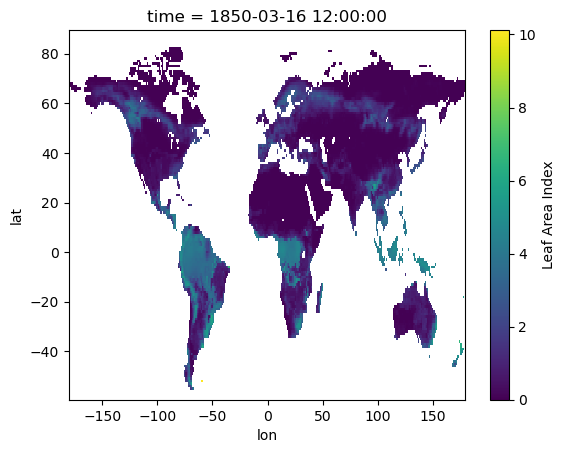

In [28]:
# ========= Have a look into the dictionary =======
print(list(ds_dict.keys()))
print(ds_dict[experiments[0]].keys())
ds_dict[list(ds_dict.keys())[0]][models[0]][variables[0]].isel(time=2).plot()

In [30]:
ds_dict = pro_dat.select_period(ds_dict[experiments[0]], start_year=1985, end_year=2014)

### Compute GSL

In [31]:
ds_dict = calculate_gsl(ds_dict, 'period') # period, winter, spring, summer, fall

CESM2
period: range(1, 13)
CMCC-CM2-SR5
period: range(1, 13)
IPSL-CM6A-LR
period: range(1, 13)


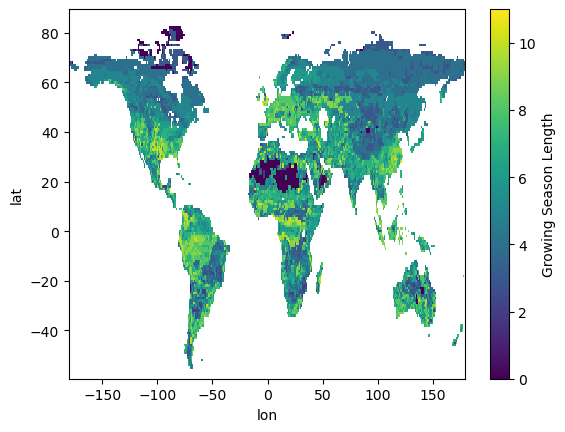

In [32]:
ds_dict[list(ds_dict.keys())[1]].gsl.plot()

### Save files

In [33]:
# =========== Store file and remove any former one ==========
# Base directory
data_path = f'{data_state}/{data_product}/{experiments[0]}/{temp_res}/'
file_path = os.path.join(BASE_DIR, data_path)
print(file_path)

/work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/


In [34]:
sd.save_files(ds_dict, file_path)

File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/gsl/CESM2.nc
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/gsl/CMCC-CM2-SR5.nc
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/gsl/IPSL-CM6A-LR.nc
